<h1>Моделирование шкалы подоходного налогообложения</h1>
<h3>Работу выполнил студент 3 курса гр. 20.б03-э Шатров Д.И. в 2023 г.</h3>

In [50]:
import numpy as np
import pandas as pd
import sympy as sp
import random
import scipy
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["figure.autolayout"] = True
import pomegranate as pg
from IPython.display import display, Math
import tkinter

<h3>Модель оптимального подоходного налогообложения (Смирнов Р.О., 2016)</h3>
Оптимизационная задача формулируется следующим образом:
\begin{align*}
&g(\eta_1,\dots,\eta_n)\mapsto min;\\
&0=\eta_0\leq\eta_1\leq\dots\leq\eta_{n-1}\leq 1;\\
&\eta_n=y_+;\\
&\sum_{i=1}^ka_{i-1}(\eta_i-\eta_{i-1})\leq\big[(1-\eta_l)a_{k-1}+\sum_{i=1}^ka_{i-1}(\eta_i-\eta_{i-1})\big]\sigma,\quad k = 1,2,\dots, n-1;\\
&\sum_{i=1}^ka_{i-1}(\eta_i-\eta_{i-1})\geq\big[(1-\eta_l)a_{k-1}+\sum_{i=1}^ka_{i-1}(\eta_i-\eta_{i-1})\big]\delta,\quad k = 1,2,\dots, n-1;\\
&a_{n-1}(\eta_n-\eta_{n-1})+\sum_{i=1}^{n-1}a_{i-1}(\eta_i-\eta_{i-1})=0
\end{align*}
где
<ul>
<li>$g(\eta)=\big[dist_2(y_{opt}\big(\cdot),y(\cdot)\big)\big]^2$ - целевая функция, $i=\overline{1,n}$,</li>
<li>$\eta_i$ - предельные ставки налога, $i=\overline{1,n}$,</li>
<li>$a_i$ - границы диапазонов налоговой шкалы,</li>
<li>$\sigma,\delta$ - параметры модели: $\delta=\frac{ln\frac{1-y_0}{1-y_+}}{ln\frac{x_+}{x_0}},\sigma=\frac{ln(1-y_0)}{ln\frac{x_-}{x_0}}$,</li>
<li>$x_-,x_+$ - необлагаемый минимум и уровень дохода, с которого налог взимается по наибольшей средней ставке,</li>
<li>$1-(1-y_{+})^{\frac{lnx_--lnx_0}{lnx_--lnx_+}}<y_0< \min\Big\{y_+,1-\frac{x_-}{x_0}\Big\}$</li>
<li>$x_0=((1-y_+)\frac{x_{+}^{\delta}}{x_{-}^{\delta}}$.</li>
<li>$y_0=1-(1-y_+)\Big(\frac{x_+}{x_0}\Big)^{\delta}$.</li>
</ul>


На первом этапе работы с реализацией модели следует ввести исходные данные, векторы левых и правых границ диапазонов распределения доходов, а также вектор частот для каждого из диапазонов, т.е. кол-во человек, попавших в тот или иной диапазон. <br><br>
Три вектора вводятся вручную, а затем автоматически собираются в таблицу, которая будет использована для расчётов по модели. Если исходные векторы отличаются по длине, работа программы на этом этапе завершается ошибкой.

In [51]:

#2019
incomedistr = [4.1
6.0
10.1
13.0
17.8
24.6
10.2
5.6
4.5
4.1
]


#2020
incomedistr = [3.5,
5.6,
9.6,
12.8,
17.9,
25.3,
10.6,
5.8,
4.7,
4.2
]

#2021 - частоты
incomedistr = [2.7,
4.5,
8.3,
11.5,
17.1,
25.9,
11.7,
6.8,
5.8,
5.7
]



#левые и правые границы диапазонов доходов
left = [0,
       7000,
       10000,
       14000,
       19000,
       27000,
       45000,
       60000,
       75000,
       100000]

right = [7000,
        10000,
        14000,
        19000,
        27000,
        45000,
        60000,
        75000,
        100000,
        300000]

#собрать исходные данные в один массив для создания модели с помощью этого массива.
assert(np.shape(left) == np.shape(right) and np.shape(left) == np.shape(incomedistr)), "Число левых и правых границ диапазонов должно совпадать с количеством частот!"
income_tuples = [(left[i],right[i],incomedistr[i]) for i in range(len(incomedistr))]
income_tuples = np.array(income_tuples);


plt.figure(figsize=(6,4))
plt.bar(range(len(incomedistr)), incomedistr, color = '#CC2020', edgecolor = "black")
plt.xticks(ticks =[k*2 for k in range(len(income_tuples[:,0])//2)], 
labels = [int(income_tuples[:,0][m*2]/2+income_tuples[:,1][m*2]/2) for m in range(len(income_tuples[:,0])//2)])
plt.title("Гистограмма доходов")
plt.show()


#print(income_tuples)

SyntaxError: invalid syntax (525332444.py, line 3)

In [72]:
class IT1:
    def __init__(self,income_tuples):
        assert isinstance(income_tuples, np.ndarray)
        self.observed_frequencies = [income_tuples[:,1][k]/sum(income_tuples[:,1]) for k in range(len(income_tuples[:,1]))]
        self.income_tuples = income_tuples
        self.x0 = 0
        self.xmax = 0
        self.xmin = 0
        self.ymin = 0
        self.ymax = 0
        self.y0_low = 0
        self.y0_high = 0
        self.y0s = []
        self.sigma = 0
        self.delta = 0
        self.y0 = 0
    #среднее интервального ряда
    def avg(self):
        mean = 0
        for k in range(len(self.income_tuples[:,0])):
            #print(k,mean)
            mean += self.income_tuples[:,2][k]*(self.income_tuples[:,1][k]+self.income_tuples[:,0][k])/2
        return np.log(mean / np.sum(self.income_tuples[:,2]))
    #оценка дисперсии интервального ряда
    def Ssq(self):
        var = 0
        for m in range(len(self.income_tuples[:,0])):
            var += self.income_tuples[:,2][m]*(np.log(self.income_tuples[:,1][m]/2+self.income_tuples[:,0][m]/2)-self.avg())**2

        return var/np.sum(self.income_tuples[:,2])
    #построить множество оптимальных налоговых ставок в предположении о шаге в tol * 100% между ставками
    def ybounds(self,xmin = 15000,xmax = 300000, x0 = 75000, ymax = 0.25, ymin = 0, tol = 0.01):
        self.x0 = x0
        self.xmax = xmax
        self.xmin = xmin
        self.ymin = ymin
        self.ymax = ymax
        self.y0_low = 1-(1-ymax)**((np.log(xmin)-np.log(x0))/(np.log(xmin)-np.log(xmax)))
        self.y0_high = min([ymax,1-xmin/x0])
        self.y0s = [rate for rate in np.arange(start = round(self.y0_low,2),stop = round(self.y0_high,2), step = tol)]
        self.y0s = list(np.around(np.array(self.y0s),2))
        return 1-(1-ymax)**((np.log(xmin)-np.log(x0))/(np.log(xmin)-np.log(xmax))),(min([ymax,1-xmin/x0]))
    
    def tax(self, x):    
        return self.yopt(x) * x
                
                
        
    #оценить сумму поступлений
    def T(self, m = 83000000):
        mean, sigma = self.avg(),self.Ssq()**0.5
        #y_0vals = [k/100 for k in range(int(self.y0_low*100), int(self.y0_high*100), 1)]
        #print(self.y0_low,self.y0_high)
        Tmax = 0
        T_at_rate = []
        paid = 0
        #imax = 0
        for r in range(len(self.y0s)):
            self.y0 = self.y0s[r]
            print(self.y0)
            paid = 0
            for j in range(len(self.income_tuples[:,1])):
                avg_x = self.income_tuples[:,0][j]/2 + self.income_tuples[:,1][j]/2
                #paid += m * self.tax(x = avg_x)*stats.norm.cdf(np.log(self.income_tuples[:,2][j]), loc = mean, scale = sigma)
                paid += m * avg_x * self.y0 *stats.norm.cdf(np.log(avg_x), loc = mean, scale = sigma)
            T_at_rate.append(paid)
        #print(T_at_rate, y_0vals)
        #for i in range(len(T_at_rate)):
        #    if T_at_rate[i] > Tmax:
        #        Tmax = T_at_rate[i]
        #        imax = i
        #self.y0 = y_0vals[imax]
        #print("Налоговые поступления максимизируются при y_0 = %0.3f.\n T = %0.2f или %d млрд руб."%(y_0vals[imax], T_at_rate[imax],T_at_rate[imax]//1000000000))
        res = pd.DataFrame({"y_0": self.y0s, "T":T_at_rate})
        return res
    #Посчитать теоретические частоты и провести тест хи-квадрат. Если нулевую гипотезу о логнормальности доходов нельзя отклонить на ур.знач. 10% и меньше, на экран выводятся функции распределения и плотности доходов. В любом случае выводятся значение статистики теста, p-value, графики теоретического и наблюдаемого распределений доходов.
    def test_distr(self, year = 2021, economy = "РФ"):
        mean, sigma = self.avg(),self.Ssq()**0.5
        #print(mean,sigma)
        expected_freq = []
        observed_freq = [t/np.sum(self.income_tuples[:,2]) 
                                for t in self.income_tuples[:,2]]
        cumulative = 0
        for k in range(len(self.income_tuples[:,0])):
            val = stats.norm.cdf(np.log(self.income_tuples[:,1][k]), loc = mean, scale = sigma)-stats.norm.cdf(np.log(self.income_tuples[:,0][k]), loc = mean, scale = sigma)
                
            
            expected_freq.append(val)
        expected_freq /= sum(expected_freq)
        #изобразить теоретическое и наблюдаемое распределения доходов на графике
        plt.figure(figsize=(6,4))
        plt.plot(observed_freq, label = "Набл.распределение", color = "#CC2020", linewidth = 2)
        plt.plot(expected_freq, label = "Теор.распределение", color = "#001488", linewidth = 2)
        plt.xlabel("Доход")
        plt.ylabel("Частота")
        plt.legend(loc="upper left")
        plt.xticks(ticks =[k*2 for k in range(len(self.income_tuples[:,0])//2)], #labels = [k*2 for k in range(len(self.income_tuples[:,0])//2)])
                   labels = [int(self.income_tuples[:,0][m*2]/2+self.income_tuples[:,1][m*2]/2) for m in range(len(self.income_tuples[:,0])//2)])
        plt.title("Распределение доходов населения %s в %d г."%(economy, year))
        chi, pval = stats.chisquare(self.observed_frequencies, f_exp = expected_freq, ddof = 2)
        if pval >= 0.1:
            #display(Math(r"S_t={}+{}P_{{t-1}}+V_t".format(self.C, self.E)))
            m, s = round(self.avg(),2), round(self.Ssq(),3)
            display(Math(r"F(x) = \frac{{1}}{{{}\sqrt{{2\pi}}}}\int_{{-\infty}}^{{x}}\frac{{1}}{{t}}\exp\Bigg(-\frac{{(\ln t - {})^2}}{{2\cdot{}}}\Bigg)\text{{dt}}".format(round(s**0.5,3),m,s)))
            
            display(Math(r"\rho(x) =\exp\Bigg(-\frac{{(\ln x - {})^2}}{{2\cdot{}}}\Bigg)".format(m,s)))
        else:
            print("Гипотезу о логнормальности распределения доходов можно отвергнуть на ур.знач. 10%.")
        
        return stats.chisquare(self.observed_frequencies, f_exp = expected_freq)
    #график зависимости средней ставки налога от уровня дохода
    def plot(self):
        pass
    def upd_delta(self):
        self.delta = (np.log(1 - self.y0)-np.log(1-self.ymax))/(np.log(self.xmax)-np.log(self.x0))
        return 0
    def upd_sigma(self):
        self.sigma = np.log(1 - self.y0)/(np.log(self.xmin)-np.log(self.x0))
        return 0
    def yopt(self, x):
        assert(x >= 0), "Предполагается неотрицательный доход."
        self.upd_sigma()
        self.upd_delta()
        if x < self.xmin:
            return 0
        elif (x >= self.xmin and x < self.x0):
            return 1 - (self.xmin/x)**self.sigma
        elif (x >= self.x0 and x < self.xmax):
            return 1 - (1 - self.ymax) * (self.xmax/x)**self.delta
        else:
            yplus = self.ymax
            return yplus
    def pick_y0(self):
        print("Выберите ставку:")
        for k in range(len(self.y0s)):
            print("%d) y_0 = %0.2f"%(k+1,self.y0s[k]))
        value = int(input("Введите номер ставки из списка, чтобы задать значение y_0"))
        self.y0 = self.y0s[value]
        self.upd_sigma()
        self.upd_delta()
        return 0
    def set_y0(self, ind = -1):
        self.y0 = self.y0s[ind]
        self.upd_sigma()
        self.upd_delta()
        return 0
        
        
        
        
        

<h2>Проверка гипотеза о логнормальности распределения доходов</h2>
Метод $test\_ distr$ позволяет проверить, является ли заданное распределение доходов $inc$ логнормальным. Используется тест хи-квадрат Пирсона:
\begin{align*}
&H_0:\quad \ln inc \sim \mathcal{N}(\overline{inc},\sigma_{inc}^2)\\
&H_1:\neg H_0,\quad\text{где $\overline{inc},\sigma_{inc}^2$ -- выборочные среднее и дисперсия распределения доходов}\\
&\text{При } H_0\quad \chi_n^2\sim\chi^2(n-1-k),\quad k = 2\text{ т.к. среднее и дисперсия выборочные.}
\end{align*}

/tmp/ipykernel_35153/3947382247.py:85: RuntimeWarning: divide by zero encountered in log
  val = stats.norm.cdf(np.log(self.income_tuples[:,1][k]), loc = mean, scale = sigma)-stats.norm.cdf(np.log(self.income_tuples[:,0][k]), loc = mean, scale = sigma)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Тест хи-квадрат.
 H_0: ln(доход) ~ N(10.682,0.796)
 Статистика: 0.795
 p-значение: 1.000


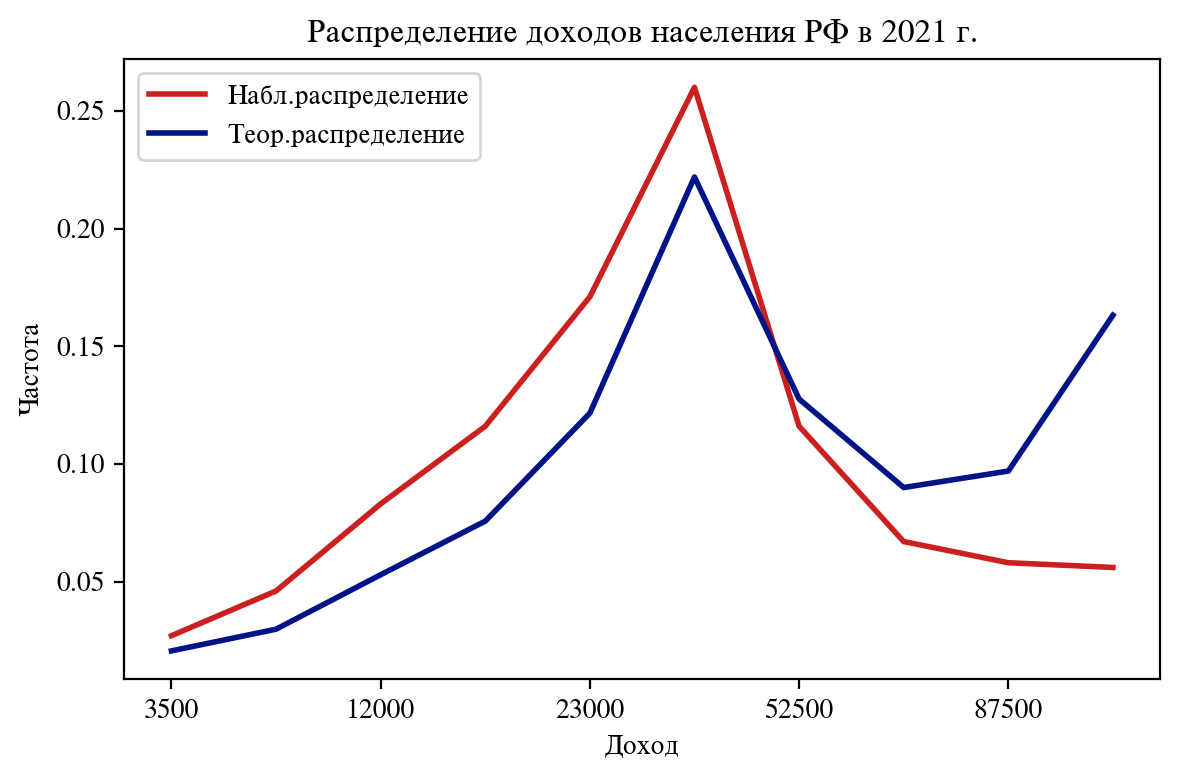

In [73]:
scaleRu21 = IT1(income_tuples)
mu = scaleRu21.avg()
sigmasq = scaleRu21.Ssq()
chi, p = scaleRu21.test_distr(year = 2021, economy = "РФ")
#print(income_tuples[:,0]/2+income_tuples[:,1]/2)
print("Тест хи-квадрат.\n H_0: ln(доход) ~ N(%0.3f,%0.3f)\n Статистика: %0.3f\n p-значение: %0.3f"%(mu, sigmasq, chi, p))
#print(scaleRu21.avg())
#print(scaleRu21.Ssq())

In [74]:
print(scaleRu21.y0_high)
scaleRu21.ybounds(xmin = 15000, xmax = 300000, x0 = 75000, ymin = 0, ymax = 0.25)
print(scaleRu21.y0_low)
print(scaleRu21.y0_high)


0
0.14320392828122464
0.25


In [75]:
print(pd.DataFrame(scaleRu21.income_tuples, columns = ['Левая граница','Правая граница','Частота']))

   Левая граница  Правая граница   Частота
0              0            7000   2241000
1           7000           10000   3818000
2          10000           14000   6889000
3          14000           19000   9628000
4          19000           27000  14193000
5          27000           45000  21580000
6          45000           60000   9628000
7          60000           75000   5561000
8          75000          100000   4814000
9         100000          300000   4648000


<h3>Максимизация налоговых поступлений</h3>
В предположении о выполнении гипотезы о логнормальности доходов функция налоговых поступлений принимает вид интеграла Римана (Смирнов Р.О., 2019):
$$T(y) = \int_0^{+\infty}y(x)mx\rho(x)dx$$
где
\begin{align*}
&\text{$y(x)$ -- средняя ставка подоходного налога для уровня дохода $x$,}\\
&\text{$m$ -- численность налогоплательщиков,}\\
&\text{$\rho(x)$ -- плотность распределения доходов населения (в смысле статистической функции).}\\
\end{align*}
С помощью метода $ybounds$ обновляется диапазон возможных значений ставки $y_0$, разграничивающей минимальную и максимальную возможную ставки. Затем метод $T$ может быть использован для вычисления суммы налоговых поступлений и определения значения ставки, максимизирующей целевой функционал. <br><br>
Метод $tax$ используется для расчёта суммы налоговых поступлений и средней ставки налога:
\begin{align*}&T(x) = \sum_{i=1}^{n+1}r_i(I_{i}-I_{i-1})\\
&y(x) = \frac{T(x)}{x}\end{align*}
где $r_i$ -- предельные ставки подоходного налога, $I_i$ -- границы диапазонов шкалы прогрессивного подоходного налога, $I_{n+1} = x$

In [76]:
scaleRu21.tax(x = 90000)

3341.550115126297

In [77]:
scaleRu21.ybounds(xmin = 15669, xmax = 313380, x0 = 78345, ymin = 0.0, ymax = 0.25)
scaleRu21.upd_sigma()
scaleRu21.upd_delta()
print(scaleRu21.y0_low,scaleRu21.y0_high)
print(scaleRu21.y0s)


0.14320392828122475 0.25
[0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24]


In [78]:
scaleRu21.T(m = 83000000)

0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24


,y_0,T
0,0.14,4.190285e+12
1,0.15,4.489591e+12
2,0.16,4.788897e+12
3,0.17,5.088204e+12
4,0.18,5.387510e+12
5,0.19,5.686816e+12
6,0.20,5.986122e+12
7,0.21,6.285428e+12
8,0.22,6.584734e+12
9,0.23,6.884040e+12


По данным РБК, общие сборы НДФЛ в 2021 г. составили около 4900 млрд руб. <br><br>
https://www.rbc.ru/economics/10/02/2022/62028cd79a7947915c1a3ed3

0.24
0.14
0.19
20090.02665348636


/tmp/ipykernel_35153/270158621.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


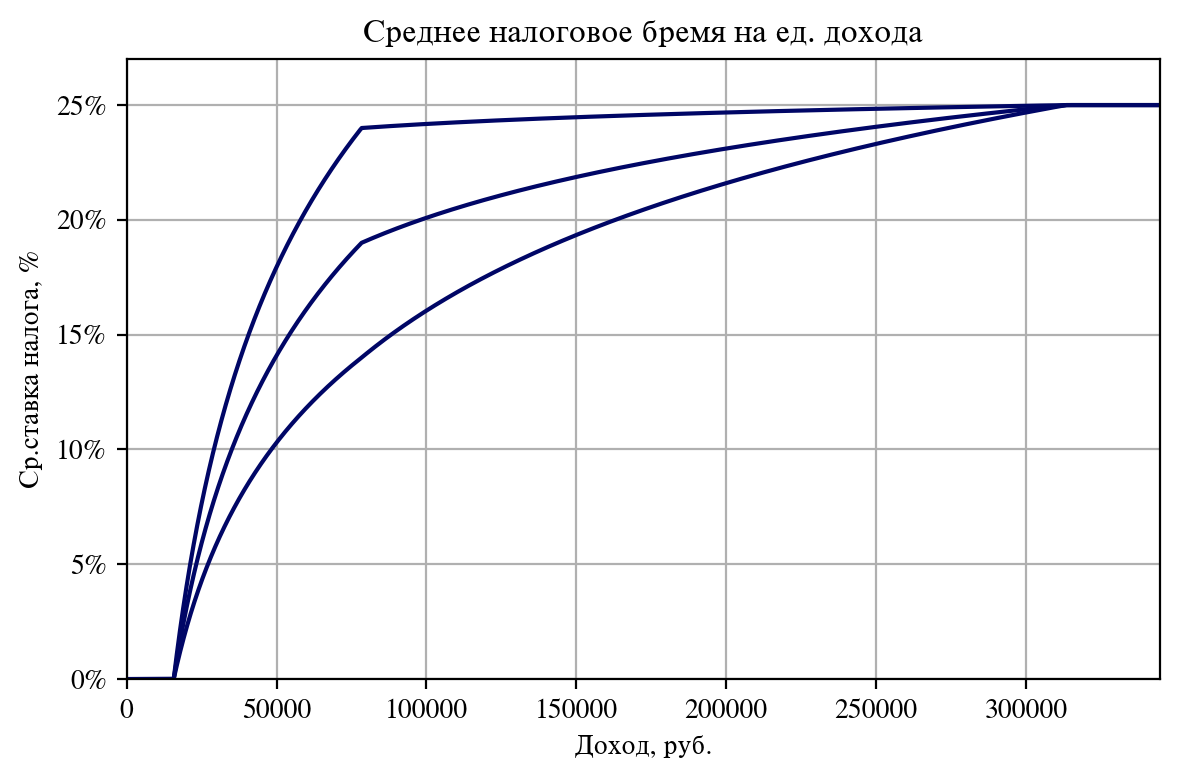

In [83]:
scaleRu21.y0 = scaleRu21.y0s[-1]
print(scaleRu21.y0)
xs = [k for k in range(1,int(scaleRu21.xmax*1.1))]
ys = [scaleRu21.yopt(k) for k in xs]
#print(scaleRu21.tax(100000))


scaleRu21.y0 = scaleRu21.y0s[0]
print(scaleRu21.y0)
scaleRu21.upd_delta()
scaleRu21.upd_sigma()
ys2 = [scaleRu21.yopt(k) for k in xs]
#print(scaleRu21.tax(100000))

scaleRu21.y0 = scaleRu21.y0s[(0+len(scaleRu21.y0s))//2]
print(scaleRu21.y0)
scaleRu21.upd_delta()
scaleRu21.upd_sigma()
ys3 = [scaleRu21.yopt(k) for k in xs]
print(scaleRu21.tax(100000))

plt.plot(ys, color = "#000666", linewidth = 1.5)
plt.plot(ys2, color = "#000666", linewidth = 1.5)
plt.plot(ys3, color = "#000666", linewidth = 1.5)
plt.ylabel("Ср.ставка налога, %")
plt.xlabel("Доход, руб.")
plt.xlim([0, max(xs)])
plt.ylim([0, max(ys)+0.02])
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 
plt.grid()
plt.title("Среднее налоговое бремя на ед. дохода");


<h3>Источники</h3>
<ol>
    <li>Р.О. Смирнов. Моделирование выбора параметров шкалы подоходного налога // Вестник Санкт-Петербургского государственного университета. Экономика.2011. Вып.4, с. 141-148. </li>
    <li>Р.О. Смирнов.Построение модельной функции распределения налогов 2019.</li>
    <li>Уровень жизни: Федеральная служба государственной статистики [Электронный ресурс]. – Режим доступа: http://www.gks.ru/wpshttps://rosstat.gov.ru/folder/13397 (Дата обращения 05.04.2023) </li>
</ol>
